<a href="https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/notebooks/hfe_three_endpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to deploy three parts(encoder/diffusion model/decoder) of Stable Diffusion in separate servers with [Hugging Face Endpoint](https://huggingface.co/inference-endpoints). All the codes for each part is based on [this notebook](https://github.com/deep-diver/keras-sd-serving/blob/main/model_sepration_without_endpoint.ipynb)

![](https://camo.githubusercontent.com/94f8a8ecd41e75c0253ed5e359892fcb0bd7ba1e008836fbffed88ad2ac564aa/68747470733a2f2f692e6962622e636f2f31644347666d392f323032322d31322d31392d332d32372d31342e706e67)

# Setup

# Install dependencies for local dev environment

`git-lfs` is only needed for clone, commit, push operations with Hugging Face Remote Repository. It is also worth noting that we don't need any dependencies except Python standard libraries when the models are is deployed. Everything under the `Setup` section is only needed for the verification on local dev environment. 

In [ ]:
!sudo apt-get update
!sudo apt-get install git-lfs
!pip install --upgrade pip
!pip install huggingface-hub

In [ ]:
!pip install tensorflow==2.11
!pip install keras-cv==0.4.0

In [ ]:
# setup cli with token
!huggingface-cli login
!git config --global credential.helper store

## Utility function to check if an object is serializable in JSON

All the messages from client to server should be serialized within JSON payload. `is_jsonable()` function simply checkes if a Python object `x` could be serialized within JSON.

In [9]:
import json

def is_jsonable(x):
    try:
        json.dumps(x)
        return True
    except (TypeError, OverflowError):
        return False

In [22]:
import matplotlib.pyplot as plt

def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

# Custom handlers

## Encoder

Encoder API has two parameters:
- `inputs`: a string for the prompt
- `batch_size`: an integer number of images to be generated

In [7]:
REPO_ID = "keras-sd/text-encoder"

In [8]:
!git lfs install
!git clone https://huggingface.co/{REPO_ID}

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'text-encoder'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 20), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [1]:
%cd /content/text-encoder

/content/text-encoder


In [10]:
%%writefile requirements.txt
keras-cv==0.4
tensorflow==2.11
tensorflow_datasets

Overwriting requirements.txt


In [35]:
%%writefile handler.py
from typing import Dict, List, Any
import sys
import base64

import tensorflow as tf
from tensorflow import keras
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from keras_cv.models.stable_diffusion.text_encoder import TextEncoderV2
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

class EndpointHandler():
    def __init__(self, path="", version="2"):
        self.MAX_PROMPT_LENGTH = 77

        self.text_encoder = self._instantiate_text_encoder(version)
        if isinstance(self.text_encoder, str):
          sys.exit(self.text_encoder)

        self.tokenizer = SimpleTokenizer()
        self.pos_ids = tf.convert_to_tensor([list(range(self.MAX_PROMPT_LENGTH))], dtype=tf.int32)    

    def _instantiate_text_encoder(self, version: str):
        if version == "1.4":
            text_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_encoder.h5",
                file_hash="4789e63e07c0e54d6a34a29b45ce81ece27060c499a709d556c7755b42bb0dc4",
            )
            text_encoder = TextEncoder(self.MAX_PROMPT_LENGTH)
            text_encoder.load_weights(text_encoder_weights_fpath)
            return text_encoder
        elif version == "2":
            text_encoder_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/ianstenbit/keras-sd2.1/resolve/main/text_encoder_v2_1.h5",
                file_hash="985002e68704e1c5c3549de332218e99c5b9b745db7171d5f31fcd9a6089f25b",
            )
            text_encoder = TextEncoderV2(self.MAX_PROMPT_LENGTH)
            text_encoder.load_weights(text_encoder_weights_fpath)
            return text_encoder
        else:
            return f"v{version} is not supported"

    def _get_unconditional_context(self):
        unconditional_tokens = tf.convert_to_tensor(
            [_UNCONDITIONAL_TOKENS], dtype=tf.int32
        )
        unconditional_context = self.text_encoder.predict_on_batch(
            [unconditional_tokens, self.pos_ids]
        )

        return unconditional_context

    def encode_text(self, prompt):
      # Tokenize prompt (i.e. starting context)
      inputs = self.tokenizer.encode(prompt)
      if len(inputs) > self.MAX_PROMPT_LENGTH:
          raise ValueError(
              f"Prompt is too long (should be <= {self.MAX_PROMPT_LENGTH} tokens)"
          )
      phrase = inputs + [49407] * (self.MAX_PROMPT_LENGTH - len(inputs))
      phrase = tf.convert_to_tensor([phrase], dtype=tf.int32)

      context = self.text_encoder.predict_on_batch([phrase, self.pos_ids])

      return context  

    def get_contexts(self, encoded_text, batch_size):
        encoded_text = tf.squeeze(encoded_text)
        if encoded_text.shape.rank == 2:
            encoded_text = tf.repeat(
                tf.expand_dims(encoded_text, axis=0), batch_size, axis=0
            )

        context = encoded_text

        unconditional_context = tf.repeat(
            self._get_unconditional_context(), batch_size, axis=0
        )  

        return context, unconditional_context

    def __call__(self, data: Dict[str, Any]) -> Dict[str, Any]:
        # get inputs 
        prompt = data.pop("inputs", data)
        batch_size = data.pop("batch_size", 1)

        encoded_text = self.encode_text(prompt)
        context, unconditional_context = self.get_contexts(encoded_text, batch_size)

        context_b64 = base64.b64encode(context.numpy().tobytes())
        context_b64str = context_b64.decode()

        unconditional_context_b64 = base64.b64encode(unconditional_context.numpy().tobytes())
        unconditional_context_b64str = unconditional_context_b64.decode()        
        
        return {"context_b64str": context_b64str, "unconditional_context_b64str": unconditional_context_b64str}

Overwriting handler.py


In [2]:
%cd /content/

/content


In [ ]:
import importlib
handler = importlib.import_module("text-encoder.handler")

my_handler = handler.EndpointHandler(path=".")

payload = {"inputs": "photograph of an astronaut riding a horse",
              "batch_size": 4}

response = my_handler(payload)

In [19]:
print(is_jsonable(response["context_b64str"]))
print(is_jsonable(response["unconditional_context_b64str"]))

True
True


In [20]:
%cd /content/text-encoder

/content/text-encoder


In [ ]:
!git config --global user.email "deep.diver.csp@gmail.com"
!git config --global user.name "Chansung Park"

!git add * 
!git commit -m "update custom handler"
!git push

## Diffusion Model

Diffusion Model API has four parameters:
- `inputs`: a list of two items consisting of the `context` and `unconditional_context` which are the outputs of the prvious(upstream) `Encoder`

- `batch_size`: an integer number of images to be generated

- `num_steps`: a integer number of iterations (timesteps). The default value is set to `25`, and this is the idential value to the official `keras-cv` implementation

- `unconditional_guidance_scale`: a float number controling how closely the image should adhere to the prompt. Larger values result in more closely adhering to the prompt, but will make the image noisier. The default value is set to `7.5`, and and this is the idential value to the official `keras-cv` implementation

In [12]:
%cd /content/

/content


In [13]:
REPO_ID = "keras-sd/diffusion-model"

In [ ]:
!git clone https://huggingface.co/{REPO_ID}

In [4]:
%cd /content/diffusion-model

/content/diffusion-model


In [24]:
%%writefile requirements.txt
keras-cv==0.4
tensorflow==2.11
tensorflow_datasets

Overwriting requirements.txt


In [5]:
%%writefile handler.py
from typing import Dict, List, Any

import sys
import base64
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModelV2

class EndpointHandler():
    def __init__(self, path="", version="2"):        
        self.seed = None

        img_height = 512
        img_width = 512
        self.img_height = round(img_height / 128) * 128
        self.img_width = round(img_width / 128) * 128        

        self.MAX_PROMPT_LENGTH = 77

        self.version = version
        self.diffusion_model = self._instantiate_diffusion_model(version)
        if isinstance(self.diffusion_model, str):
          sys.exit(self.diffusion_model)

    def _instantiate_diffusion_model(self, version: str):
        if version == "1.4":
            diffusion_model_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_diffusion_model.h5",
                file_hash="8799ff9763de13d7f30a683d653018e114ed24a6a819667da4f5ee10f9e805fe",
            )
            diffusion_model = DiffusionModel(self.img_height, self.img_width, self.MAX_PROMPT_LENGTH)
            diffusion_model.load_weights(diffusion_model_weights_fpath)
            return diffusion_model
        elif version == "2":
            diffusion_model_weights_fpath = keras.utils.get_file(
                origin="https://huggingface.co/ianstenbit/keras-sd2.1/resolve/main/diffusion_model_v2_1.h5",
                file_hash="c31730e91111f98fe0e2dbde4475d381b5287ebb9672b1821796146a25c5132d",
            )
            diffusion_model = DiffusionModelV2(self.img_height, self.img_width, self.MAX_PROMPT_LENGTH)
            diffusion_model.load_weights(diffusion_model_weights_fpath)
            return diffusion_model
        else:
            return f"v{version} is not supported"

    def _get_initial_diffusion_noise(self, batch_size, seed):
        if seed is not None:
            return tf.random.stateless_normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4),
                seed=[seed, seed],
            )
        else:
            return tf.random.normal(
                (batch_size, self.img_height // 8, self.img_width // 8, 4)
            )

    def _get_initial_alphas(self, timesteps):
        alphas = [_ALPHAS_CUMPROD[t] for t in timesteps]
        alphas_prev = [1.0] + alphas[:-1]

        return alphas, alphas_prev

    def _get_timestep_embedding(self, timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        freqs = tf.math.exp(
            -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    def __call__(self, data: Dict[str, Any]) -> str:
        # get inputs 
        contexts = data.pop("inputs", data)
        batch_size = data.pop("batch_size", 1)

        context = base64.b64decode(contexts[0])
        context = np.frombuffer(context, dtype="float32")
        if self.version == "1.4":
          context = np.reshape(context, (batch_size, 77, 768))
        else:
          context = np.reshape(context, (batch_size, 77, 1024))

        unconditional_context = base64.b64decode(contexts[1])
        unconditional_context = np.frombuffer(unconditional_context, dtype="float32")
        if self.version == "1.4":
          unconditional_context = np.reshape(unconditional_context, (batch_size, 77, 768))
        else:
          unconditional_context = np.reshape(unconditional_context, (batch_size, 77, 1024))

        num_steps = data.pop("num_steps", 25)
        unconditional_guidance_scale = data.pop("unconditional_guidance_scale", 7.5)

        latent = self._get_initial_diffusion_noise(batch_size, self.seed)

        # Iterative reverse diffusion stage
        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas, alphas_prev = self._get_initial_alphas(timesteps)
        progbar = keras.utils.Progbar(len(timesteps))
        iteration = 0
        for index, timestep in list(enumerate(timesteps))[::-1]:
            latent_prev = latent  # Set aside the previous latent vector
            t_emb = self._get_timestep_embedding(timestep, batch_size)
            unconditional_latent = self.diffusion_model.predict_on_batch(
                [latent, t_emb, unconditional_context]
            )
            latent = self.diffusion_model.predict_on_batch([latent, t_emb, context])
            latent = unconditional_latent + unconditional_guidance_scale * (
                latent - unconditional_latent
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            pred_x0 = (latent_prev - math.sqrt(1 - a_t) * latent) / math.sqrt(a_t)
            latent = latent * math.sqrt(1.0 - a_prev) + math.sqrt(a_prev) * pred_x0
            iteration += 1
            progbar.update(iteration)

        latent_b64 = base64.b64encode(latent.numpy().tobytes())
        latent_b64str = latent_b64.decode()

        return latent_b64str

Overwriting handler.py


In [6]:
%cd /content/

/content


In [7]:
import importlib

handler = importlib.import_module("diffusion-model.handler")

my_handler = handler.EndpointHandler(path=".")

payload = {"inputs": [response["context_b64str"], response["unconditional_context_b64str"]],
           "batch_size": 4}

response = my_handler(payload)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


25/25 [==============================] - 83s 3s/step


In [10]:
is_jsonable(response)

True

In [11]:
%cd /content/diffusion-model

/content/diffusion-model


In [ ]:
!git add * 
!git commit -m "update custom handler"
!git push

## Decoder

Decoder API has two parameters:
- `inputs`: `latent` from the outputs of the prvious(upstream) Diffusion Model
- `batch_size`: an integer number of images to be generated

In [13]:
%cd /content/

/content


In [14]:
REPO_ID = "keras-sd/decoder"

In [ ]:
!git clone https://huggingface.co/{REPO_ID}

In [16]:
%cd /content/decoder

/content/decoder


In [17]:
%%writefile requirements.txt
keras-cv==0.4
tensorflow==2.11
tensorflow_datasets

Overwriting requirements.txt


In [18]:
%%writefile handler.py
from typing import Dict, List, Any

import base64
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras_cv.models.stable_diffusion.decoder import Decoder

class EndpointHandler():
    def __init__(self, path=""):        
        img_height = 512
        img_width = 512
        img_height = round(img_height / 128) * 128
        img_width = round(img_width / 128) * 128
        
        self.decoder = Decoder(img_height, img_width)
        decoder_weights_fpath = keras.utils.get_file(
            origin="https://huggingface.co/fchollet/stable-diffusion/resolve/main/kcv_decoder.h5",
            file_hash="ad350a65cc8bc4a80c8103367e039a3329b4231c2469a1093869a345f55b1962",
        )
        self.decoder.load_weights(decoder_weights_fpath)

    def __call__(self, data: Dict[str, Any]) -> str:
        # get inputs 
        latent = data.pop("inputs", data)
        batch_size = data.pop("batch_size", 1)

        latent = base64.b64decode(latent)
        latent = np.frombuffer(latent, dtype="float32")
        latent = np.reshape(latent, (batch_size, 64, 64, 4))

        decoded = self.decoder.predict_on_batch(latent)
        decoded = ((decoded + 1) / 2) * 255
        images = np.clip(decoded, 0, 255).astype("uint8")

        images_b64 = base64.b64encode(images.tobytes())
        images_b64str = images_b64.decode()

        return images_b64str             

Overwriting handler.py


In [19]:
%cd /content/

/content


In [ ]:
import importlib

handler = importlib.import_module("decoder.handler")
# latent = response

# init pipeline
my_handler = handler.EndpointHandler(path=".")

# prepare sample playoad
payload = {"inputs": response,
           "batch_size": 4}

# test the pipeline
response = my_handler(payload)

In [21]:
is_jsonable(response)

True

In [23]:
import base64
import numpy as np

images = base64.b64decode(response)
images = np.frombuffer(images, dtype="uint8")
images = np.reshape(images, (4, 512, 512, 3))

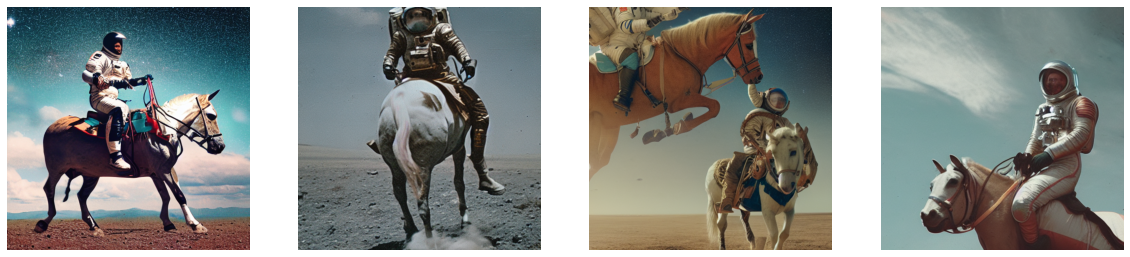

In [24]:
plot_images(images)

In [25]:
%cd /content/decoder

/content/decoder


In [ ]:
!git add * 
!git commit -m "update custom handler"
!git push

# Interacting with Hugging Face Endpoints

This final section demonstrates how to text-to-image generation by interacting with the three Hugging Face Endpoints. Before proceeding this section, we assume that you have deployed each part(encoder, diffusion model, decoder) successfully on Hugging Face Endpoint. If you are not fmailiar with Hugging Face Endpoint, please read [this notebook](https://github.com/deep-diver/keras-sd-serving/blob/main/hf_single_endpoint.ipynb) first.

So, you may have three Endpoints like the screenshot below:

![](https://i.ibb.co/v1VPycH/image.png)

## Common

In [ ]:
import json
import requests as r

HF_TOKEN = ""
PROMPT = "photograph of an astronaut riding a horse"
BATCH_SIZE = 4

headers = {
    "Authorization": f"Bearer {HF_TOKEN}",
    "Content-Type": "application/json",
}


## Request to text encoder

In [ ]:
ENDPOINT_URL = "https://ry7ghe4x1m76femw.us-east-1.aws.endpoints.huggingface.cloud"

payload = {"inputs": PROMPT,
           "batch_size": BATCH_SIZE}
response = r.post(ENDPOINT_URL, headers=headers, json=payload)

In [ ]:
response

<Response [200]>

## Request to diffusion model

In [ ]:
response_json = json.loads(response.content)

In [ ]:
ENDPOINT_URL = "https://wz6bwtuxfqvvinav.us-east-1.aws.endpoints.huggingface.cloud"

payload = {"inputs": [response_json['context_b64str'], response_json['unconditional_context_b64str']],
           "batch_size": BATCH_SIZE}
response = r.post(ENDPOINT_URL, headers=headers, json=payload)

In [ ]:
response

<Response [200]>

## Request to decoder

In [ ]:
latent_b64str = response.content.decode()

In [ ]:
ENDPOINT_URL = "https://rnqq7nt7dublw3xg.us-east-1.aws.endpoints.huggingface.cloud"

payload = {"inputs": latent_b64str,
           "batch_size": BATCH_SIZE}
response = r.post(ENDPOINT_URL, headers=headers, json=payload)

In [ ]:
response

<Response [200]>

## Display the generated images

In [ ]:
import base64
import numpy as np

images = base64.b64decode(response.content)
images = np.frombuffer(images, dtype="uint8")
images = np.reshape(images, (BATCH_SIZE, 512, 512, 3))

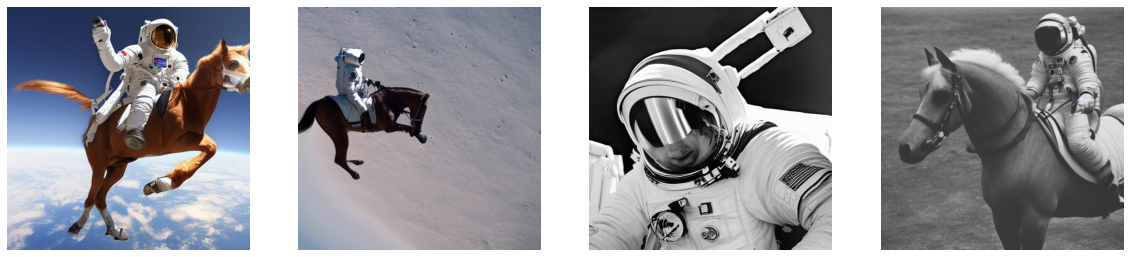

In [ ]:
plot_images(images)